In [1]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot
from pandas import Series, datetime
from pandas.tools.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from xgboost import XGBClassifier

/Users/mhafizhussin/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Loading the dataset to a dataframe
main_df = pd.read_csv('data_for_modelling_2.csv')
print(main_df.shape)
print(main_df.dtypes)

(210, 11)
Unnamed: 0      int64
rsi           float64
sma           float64
lma           float64
adx           float64
macd          float64
signal        float64
us_china      float64
malaysia      float64
Score           int64
class          object
dtype: object


In [7]:
# Separate the dataframe for input(X) and output variables(y)
# merged_dataframe = merged_dataframe.dropna()
X = main_df.loc[:,'rsi':'Score']
y = main_df.loc[:,'class']
# Set the validation size, i.e the test set to 20%
validation_size = 0.20
# Split the dataset to test and train sets
# Split the initial 70% of the data as training set and the remaining 30% data as the testing set
train_size = int(len(X.index) * 0.7)
print(len(y))
print(train_size)

210
147


In [8]:
X_train, X_test = X.loc[0:train_size, :], X.loc[train_size: len(X.index), :]
y_train, y_test = y[0:train_size+1], y.loc[train_size: len(X.index)]
print('Observations: %d' % (len(X.index)))
print('X Training Observations: %d' % (len(X_train.index)))
print('X Testing Observations: %d' % (len(X_test.index)))
print('y Training Observations: %d' % (len(y_train)))
print('y Testing Observations: %d' % (len(y_test)))

Observations: 210
X Training Observations: 148
X Testing Observations: 63
y Training Observations: 148
y Testing Observations: 63


In [9]:
# MOdels
num_folds = 10
scoring = 'accuracy'
# Append the models to the models list
models = []
models.append(('LR' , LogisticRegression()))
models.append(('LDA' , LinearDiscriminantAnalysis()))
models.append(('KNN' , KNeighborsClassifier()))
models.append(('CART' , DecisionTreeClassifier()))
models.append(('NB' , GaussianNB()))
models.append(('SVM' , SVC()))
models.append(('RF' , RandomForestClassifier(n_estimators=50)))
models.append(('XGBoost', XGBClassifier()))

In [20]:
# Evaluate each algorithm for accuracy
results = []
names = []
'''
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg) '''

for name, model in models:
    clf = model
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy_train = accuracy_score(y_train, clf.predict(X_train))
    accuracy_test = accuracy_score(y_test, clf.predict(X_test))
#     print(name + ': Train Accuracy:{: .2f}%'.format(accuracy_train*100))
    print(name +': Test Accuracy:{: .2f}%'.format(accuracy_test*100))
#     accu_score = accuracy_score(y_test, y_pred)
#     print(name + ": " + str(accu_score))

LR: Train Accuracy: 58.78%
LR: Test Accuracy: 44.44%
LDA: Train Accuracy: 66.22%
LDA: Test Accuracy: 34.92%
KNN: Train Accuracy: 73.65%
KNN: Test Accuracy: 49.21%
CART: Train Accuracy: 100.00%
CART: Test Accuracy: 53.97%
NB: Train Accuracy: 60.14%
NB: Test Accuracy: 39.68%
SVM: Train Accuracy: 97.30%
SVM: Test Accuracy: 60.32%
RF: Train Accuracy: 100.00%
RF: Test Accuracy: 44.44%
XGBoost: Train Accuracy: 94.59%
XGBoost: Test Accuracy: 44.44%


In [64]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(X)
transformed = pca.transform(X)

transformed.shape
print(type(transformed))

# Dump components relations with features:
print pd.DataFrame(pca.components_,columns=X.columns,index = ['PC-1','PC-2','PC-3'])

<type 'numpy.ndarray'>
           rsi       sma       lma       adx      macd    signal  us_china  \
PC-1  0.983074 -0.000854 -0.001948  0.133885  0.005727  0.003558 -0.122311   
PC-2  0.080041 -0.006525 -0.006765  0.287465  0.002902  0.003592  0.954160   
PC-3 -0.146580 -0.003079 -0.002838  0.895360  0.005567  0.008195 -0.264574   

      malaysia     Score  
PC-1  0.025120  0.000201  
PC-2 -0.020554 -0.002065  
PC-3 -0.326682  0.002896  


In [54]:
pca_df = pd.DataFrame(transformed)

X_train_pca, X_test_pca = pca_df.loc[0:train_size, :], pca_df.loc[train_size: len(X.index), :]


for name, model in models:
    clf = model
    clf.fit(X_train_pca, y_train)
    y_pred_pca = clf.predict(X_test_pca)
    score = accuracy_score(y_test, y_pred_pca)
    print(name +': Test Accuracy:{: .2f}%'.format(score*100))
#     print(name +"--Score is "+ str(score))

# clf = XGBClassifier(n_estimators=500, max_depth=3)
# clf.fit(X_train_pca, y_train)
# y_pred_pca = clf.predict(X_test_pca)
# score = accuracy_score(y_test, y_pred_pca)
# print("Score is "+ str(score))

LR: Test Accuracy: 36.51%
LDA: Test Accuracy: 36.51%
KNN: Test Accuracy: 53.97%
CART: Test Accuracy: 61.90%
NB: Test Accuracy: 41.27%
SVM: Test Accuracy: 61.90%
RF: Test Accuracy: 57.14%
XGBoost: Test Accuracy: 60.32%


In [27]:
pca_df = pd.DataFrame(transformed)

X_train_pca, X_test_pca = pca_df.loc[0:train_size, :], pca_df.loc[train_size: len(X.index), :]

clf = XGBClassifier(n_estimators=500, max_depth=3)
clf.fit(X_train_pca, y_train)
y_pred_pca = clf.predict(X_test_pca)
score = accuracy_score(y_test, y_pred_pca)
print("Score is "+ str(score))

Score is 0.6349206349206349


#Here, we see that an accuracy of more than 50% in a test dataset which means that 50% of the time our prediction will be correct.

In [38]:
# The best model = SVM, 
cls = SVC().fit(X_train, y_train)
accuracy_train = accuracy_score(y_train, cls.predict(X_train))
accuracy_test = accuracy_score(y_test, cls.predict(X_test))

print('\nTrain Accuracy:{: .2f}%'.format(accuracy_train*100))
print('Test Accuracy:{: .2f}%'.format(accuracy_test*100))


Train Accuracy: 97.30%
Test Accuracy: 60.32%


In [46]:
# See the decision tree

In [50]:
dtree=DecisionTreeClassifier()
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

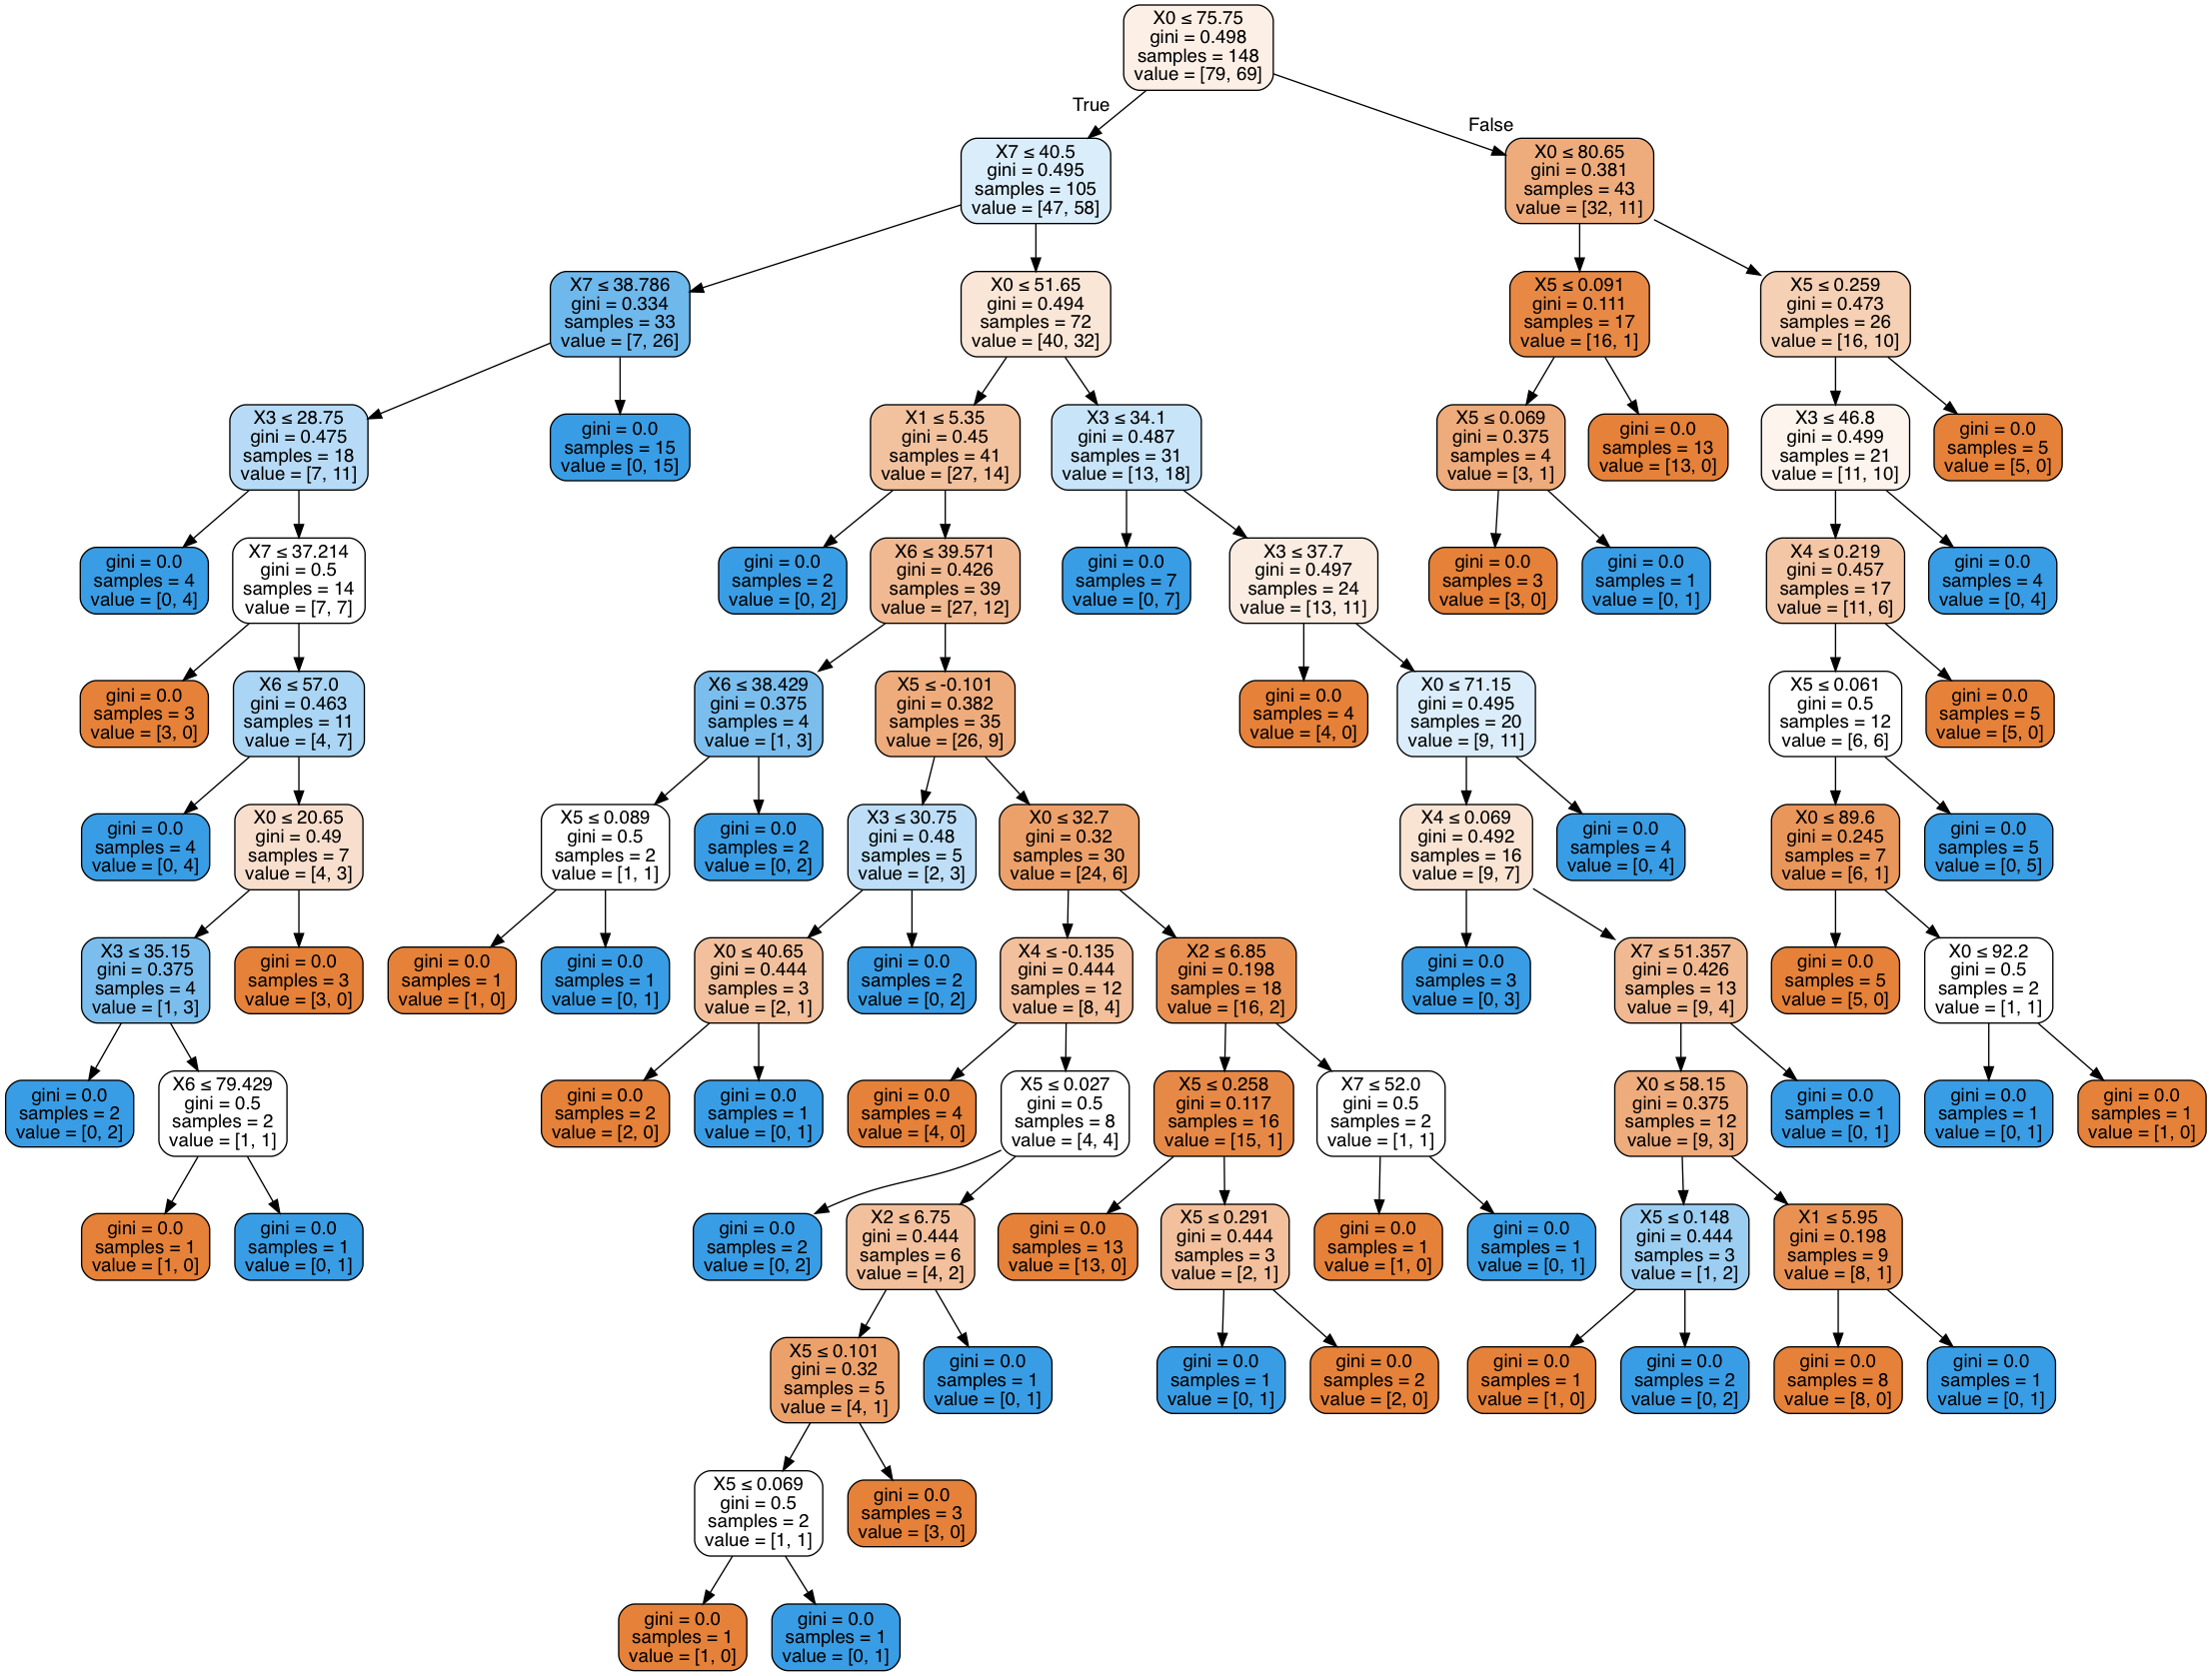

In [53]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

5. Feature Importances:

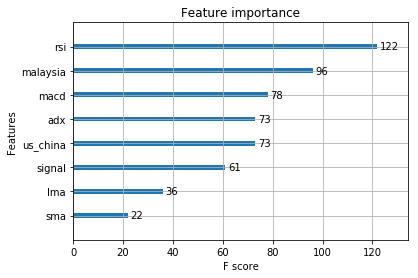

In [60]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)

from matplotlib import pyplot
from xgboost import plot_importance
plot_importance(model_xgb, max_num_features=10) # top 10 most important features
plt.show()